In [148]:
import numpy as np
import torch
import torch.functional as F
import pandas as pd

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
ps = PorterStemmer()
wnl = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [89]:
df = pd.read_csv('train_data.tsv', sep='\t')

In [90]:
y = df['label'].to_numpy()

In [91]:
x = df['text_a']

In [92]:
x

0       #Coronavirus:  Prime  Minister  Boris  Johnson...
1       Global  coronavirus  deaths  exceed  800000  h...
2       The  US  has  the  highest  number  of  #COVID...
3       Many  more  cities  and  states  will  start  ...
4       #IndiaFightsCorona:  Japan  commits  Rs  3500 ...
                              ...                        
6328    The  fight  against  Covid  takes  warriors.  ...
6329    The  "proper"  way  to  wear  a  surgical  mas...
6330    Our  daily  update  is  published.  We’ve  now...
6331    Singapore's  Health  ministry  issued  an  adv...
6332    Former  Rep.  Trey  Gowdy  wrote  essay  past ...
Name: text_a, Length: 6333, dtype: object

# Preprocessing

We will remove URLs, special signs (everything apart from letters and spaces), remove repeated whitespace characters, transform text to lowercase, filter out stopwords and stem the remaining words.

In [93]:
def filter_stem(text):
  tokens = nltk.word_tokenize(text)
  filtered = [word for word in tokens if not word in stopwords.words('english')]
  stemmed = [ps.stem(word) for word in filtered]
  #lemmatized = [wnl.lemmatize(word) for word in stemmed]
  return " ".join(stemmed)
  
def preprocess(df):
  df = df.replace(r'http\S+', '', regex=True)
  df = df.replace(r'[^A-Za-z ]+', ' ', regex=True)
  df = df.apply(lambda txt: txt.lower())
  df = df.replace(r'\s\s+', ' ', regex=True)
  df = df.apply(filter_stem)
  
  return df


In [94]:
x_prepr = preprocess(x)

# Feature construction and basic stats



In [95]:
def df_to_array(df):
  a = []
  for i in range(df.shape[0]):
    a.append(df[i])
  return a

def document_term_matrix(df):
  ar = df_to_array(df)
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(ar)
  words = vectorizer.get_feature_names_out()
  dtm = pd.DataFrame(X.toarray(), columns=words)
  return dtm

In [96]:
dtm = document_term_matrix(x_prepr)

In [97]:
dtm.sum(axis=0)

aa          2
aadab       1
aadajoli    1
aai         1
aaj         3
           ..
zoolog      2
zoom        1
zubymus     1
zurich      1
zydu        2
Length: 8811, dtype: int64

## Word frequncy visualization

Text(0, 0.5, 'freq.')

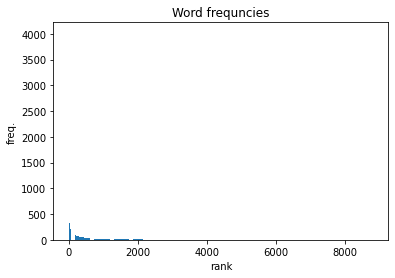

In [98]:
plt.bar(np.arange(dtm.shape[1]), np.sort(dtm.sum(axis=0).to_numpy())[::-1])
plt.title("Word frequncies")
plt.xlabel("rank")
plt.ylabel("freq.")

In [99]:
np.sort(dtm.sum(axis=0).to_numpy())

array([   1,    1,    1, ..., 1657, 2059, 4020])

Text(0, 0.5, 'freq.')

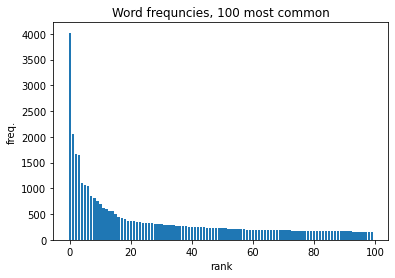

In [100]:
plt.bar(np.arange(100), np.sort(dtm.sum(axis=0).to_numpy())[::-1][:100])
plt.title("Word frequncies, 100 most common")
plt.xlabel("rank")
plt.ylabel("freq.")

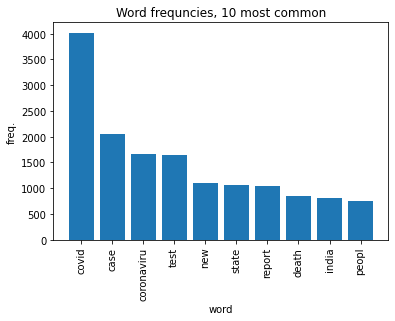

In [101]:
plt.bar(np.arange(10), np.sort(dtm.sum(axis=0).to_numpy())[::-1][:10])
plt.title("Word frequncies, 10 most common")
plt.xlabel("word")
plt.ylabel("freq.")

words = dtm.sum(axis=0).sort_values(ascending=False).index[:10]
plt.xticks(np.arange(10), words, rotation=90)
plt.show()

In [102]:
def load_to_dtm(filename):
  df = pd.read_csv(filename, sep='\t')
  y = df['label'].to_numpy()
  x = df['text_a']
  x_prepr = preprocess(x)
  dtm = document_term_matrix(x_prepr)
  return x_prepr, y, dtm

In [103]:
_,_,dtm = load_to_dtm('train_data.tsv')

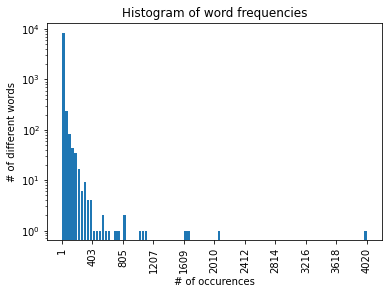

In [104]:
freqs = dtm.sum(axis=0).to_numpy()
n_bins=100
hist = np.histogram(freqs, n_bins)
plt.bar(np.arange(n_bins), hist[0])
plt.yscale('log')
plt.title("Histogram of word frequencies")
plt.ylabel("# of different words")
plt.xlabel("# of occurences")
plt.xticks((np.arange(n_bins + 1) - 0.5)[::10], np.around(hist[1][::10], 0).astype(int), rotation=90)
plt.show()

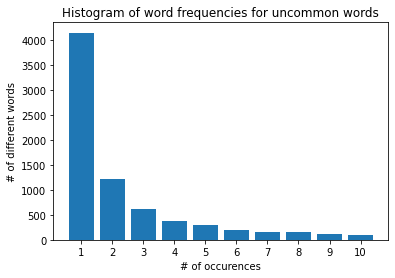

In [105]:
freqs = dtm.sum(axis=0).to_numpy()
freqs10 = freqs[freqs <= 10]
n_bins=10
hist = np.histogram(freqs10, n_bins)
plt.bar(np.arange(n_bins), hist[0])
plt.title("Histogram of word frequencies for uncommon words")
plt.ylabel("# of different words")
plt.xlabel("# of occurences")
plt.xticks(np.arange(n_bins), np.arange(n_bins) + 1)
plt.show()

In [106]:
(freqs > 16).sum()

1013

In [107]:
print("Average # of words per tweet: {:.4}".format(dtm.sum(axis=1).to_numpy().mean()))

Average # of words per tweet: 16.02


In [108]:
most_common = dtm.sum(axis=0).sort_values(ascending=False).index[:1000]
dtmc = dtm[most_common]

In [109]:
x = dtmc
dtmc.sum(axis=0)

covid         4020
case          2059
coronaviru    1657
test          1637
new           1109
              ... 
nyc             17
quot            17
lock            17
perform         17
spit            17
Length: 1000, dtype: int64

We observe that after stemming and removing stopwords, the most common words are almost all related to Covid pandemic. We also observe that of the 8800 different words, almost half appear only once. Overall, the vast majority of words appear only a few times, whereas the few most common words appear very often.

We transformed the datatset into a Document-Term Matrix (each element represents the number of occurances of a specific word in a specific tweet). We then decided to retain only the first 1000 most common words - we kept 1000 features - in order to remove most of the words that appear very rarely and are therefore more prone to noise and would probably cause overfitting in some models.

# Modeling

We will try using majority classifier, kNN with different parameters(number of neighbors), SVM, Bayesian classifier and Random Forest with different parameters.

## Majority classifier

In [110]:
def get_default_classifier(x, y):
  def model(x):
    return np.full(x.shape[0], np.median(y))
  return model

In [111]:
default_classifier = get_default_classifier(x, y)

## kNN

In [112]:
knn10_clf = neighbors.KNeighborsClassifier(10, weights="distance")
knn10_clf.fit(x, y)

knn5_clf = neighbors.KNeighborsClassifier(5, weights="distance")
knn5_clf.fit(x, y)

knn50_clf = neighbors.KNeighborsClassifier(50, weights="distance")
knn50_clf.fit(x, y)

knn1_clf = neighbors.KNeighborsClassifier(1, weights="distance")
knn1_clf.fit(x, y)

KNeighborsClassifier(n_neighbors=1, weights='distance')

## SVM

In [113]:
svm_clf = svm.SVC()
svm_clf.fit(x, y)

SVC()

## Bayes

In [114]:
b_clf = GaussianNB()
b_clf.fit(x, y)

GaussianNB()

## Random Forest

In [115]:
rf_clf = RandomForestClassifier(100)
rf_clf.fit(x, y)

rf20_clf = RandomForestClassifier(20)
rf20_clf.fit(x, y)

rf250_clf = RandomForestClassifier(250)
rf250_clf.fit(x, y)

rf1000_clf = RandomForestClassifier(1000)
rf1000_clf.fit(x, y)

RandomForestClassifier(n_estimators=1000)

# Evaluation

In [116]:
def CA(model, x, y):
  yh = model(x)
  yh = np.round(yh).reshape(-1)
  y = y.reshape(-1)

  correct = yh == y
  n_correct = np.sum(correct)
  all = correct.shape[0]
  return n_correct/all


def F1(model, x, y):
  yh = model(x)
  yh = np.round(yh).reshape(-1)
  y = y.reshape(-1)

  tp = np.sum(y * yh)
  fp = np.sum((1-y) * yh)
  fn = np.sum((1-yh) * y)

  precision = np.sum(yh*y) / np.sum(yh)
  recall = np.sum(yh*y) / np.sum(y)
  #return tp / (tp + (fp + fn)/2)
  return 2 / (precision**(-1) + recall**(-1))

In [117]:
_, y_test, dtm_test = load_to_dtm('test_data.tsv')

In [118]:
for word in most_common:
  if word not in dtm_test:
    dtm_test[word] = 0
    
x_test = dtm_test[most_common]

## Majority classifier

In [119]:
CA_majority = CA(default_classifier, x_test, y_test)
print("CA = {:.3}".format(CA_majority))

CA = 0.523


In [120]:
F1_majority = F1(default_classifier, x_test, y_test)
print("F1 = {:.3}".format(F1_majority))

F1 = 0.687


## kNN

In [121]:
CA_knn5 = CA(knn5_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_knn5))
F1_knn5 = F1(knn5_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_knn5))

CA = 0.754
F1 = 0.699


In [122]:
CA_knn10 = CA(knn10_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_knn10))
F1_knn10 = F1(knn10_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_knn10))

CA = 0.728
F1 = 0.652


In [123]:
CA_knn50 = CA(knn50_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_knn50))
F1_knn50 = F1(knn50_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_knn50))

CA = 0.664
F1 = 0.53


In [124]:
CA_knn1 = CA(knn1_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_knn1))
F1_knn1 = F1(knn1_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_knn1))

CA = 0.775
F1 = 0.746


## SVM

In [125]:
CA_svm = CA(svm_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_svm))
F1_svm = F1(svm_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_svm))

CA = 0.914
F1 = 0.916


## Bayes

In [126]:
CA_b = CA(b_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_b))
F1_b = F1(b_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_b))

CA = 0.858
F1 = 0.85


## Random Forest

In [127]:
CA_rf20 = CA(rf20_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_rf20))
F1_rf20 = F1(rf20_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_rf20))

CA = 0.886
F1 = 0.891


In [128]:
CA_rf = CA(rf_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_rf))
F1_rf = F1(rf_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_rf))

CA = 0.905
F1 = 0.908


In [129]:
CA_rf250 = CA(rf250_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_rf250))
F1_rf250 = F1(rf250_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_rf250))

CA = 0.905
F1 = 0.909


In [130]:
CA_rf1000 = CA(rf1000_clf.predict, x_test, y_test)
print("CA = {:.3}".format(CA_rf1000))
F1_rf1000 = F1(rf1000_clf.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_rf1000))

CA = 0.906
F1 = 0.91


## Visualization

In [131]:
CAs = [CA_majority, CA_knn1, CA_knn5, CA_knn10, CA_knn50, CA_svm, CA_b, CA_rf20, CA_rf, CA_rf250, CA_rf1000]
F1s = [F1_majority, F1_knn1, F1_knn5, F1_knn10, F1_knn50, F1_svm, F1_b, F1_rf20, F1_rf, F1_rf250, F1_rf1000]
model_names = ["Majority", "kNN, k=1", "kNN, k=5", "kNN, k=10", "kNN, k=50", "SVM", "Bayes", "R.F., 20 trees", "R.F., 100 trees", "R.F., 250 trees", "R.F., 1000 trees"]

In [132]:
results = pd.DataFrame({"model": model_names, "CA": CAs, "F1": F1s}).sort_values("CA")

In [133]:
results

,model,CA,F1
0,Majority,0.523364,0.687117
4,"kNN, k=50",0.664486,0.530105
3,"kNN, k=10",0.727570,0.652355
2,"kNN, k=5",0.754206,0.699085
1,"kNN, k=1",0.775234,0.745637
6,Bayes,0.858411,0.850222
7,"R.F., 20 trees",0.886449,0.890590
8,"R.F., 100 trees",0.904673,0.908273
9,"R.F., 250 trees",0.905140,0.908846
10,"R.F., 1000 trees",0.906075,0.909987


Text(0.5, 1.0, 'Accuracy')

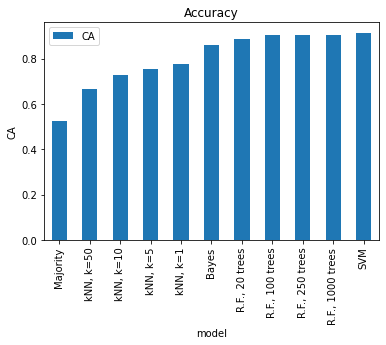

In [134]:
results.plot.bar("model", "CA")
plt.ylabel("CA")
plt.title("Accuracy")

Text(0.5, 1.0, 'F1')

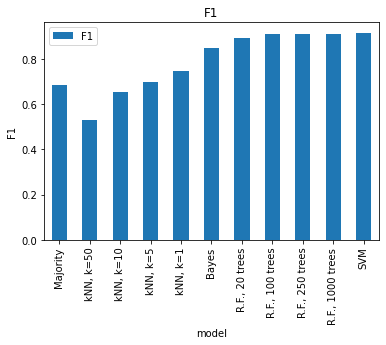

In [135]:
results.plot.bar("model", "F1")
plt.ylabel("F1")
plt.title("F1")

SVM was the best of traditional classifiers, followed by Random Forests, then Bayesian Classifier and then kNN. The majority classifier had worse CA then all other classifiers, but better F1 than the poorest two kNNs.

Looking at RFs with different number of trees, the ones with the more trees had both better CA and F1, probably due to them being more flexible and so being able to fit the data better. 

In k-Nearest Neighbors, the smaller the k the better the results (both CA and F1), again due to them being able to fit the data better. 

(too flexible models in general could lead to overfitting and consequently poorer results, but this was not observable using our models on this dataset)

Our best-performing traditional model, SVM, had both better accuracy and F1 than half of the baseline models.

# BERT

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
from tqdm import tqdm

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [185]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer3 = RobertaTokenizer.from_pretrained('roberta-large')
def preprocess_nn(df):
  df = df.replace(r'http\S+', '', regex=True)
  df = df.replace(r'[^A-Za-z0-9?!.,-:;]+', ' ', regex=True)  
  df = df.replace(r'\s\s+', ' ', regex=True)
  tokenized = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors='pt') for text in df]

  input_ids = [e['input_ids'].reshape(-1) for e in tokenized]
  attention_mask = [e['attention_mask'].reshape(-1) for e in tokenized]

  input_ids = torch.stack(input_ids).to(device)
  attention_mask = torch.stack(attention_mask).to(device)

  return input_ids, attention_mask

def preprocess_nn2(df):
  tokenized = [tokenizer2(text, padding='max_length', max_length=512, truncation=True, return_tensors='pt') for text in df]

  input_ids = [e['input_ids'].reshape(-1) for e in tokenized]
  attention_mask = [e['attention_mask'].reshape(-1) for e in tokenized]

  input_ids = torch.stack(input_ids).to(device)
  attention_mask = torch.stack(attention_mask).to(device)

  return input_ids, attention_mask

def preprocess_nn3(df):
  tokenized = [tokenizer3(text, padding='max_length', max_length=512, truncation=True, return_tensors='pt') for text in df]

  input_ids = [e['input_ids'].reshape(-1) for e in tokenized]
  attention_mask = [e['attention_mask'].reshape(-1) for e in tokenized]

  input_ids = torch.stack(input_ids).to(device)
  attention_mask = torch.stack(attention_mask).to(device)

  return input_ids, attention_mask

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [32]:
input_ids, attention_mask = preprocess_nn(df['text_a'])

In [190]:
def run_bert(input_ids, attention_mask):
  bert = BertModel.from_pretrained('bert-base-cased')
  bert.to(device)
  outputs = torch.zeros((input_ids.size()[0], 768))
  batch = 10
  print("starting")
  for i in tqdm(range(0, input_ids.size()[0], batch)):
    _, output = bert(input_ids=input_ids[i:i+batch], attention_mask=attention_mask[i:i+batch], return_dict=False)
    outputs[i:i+batch] = output
  return outputs

def run_bert2(input_ids, attention_mask):
  bert = BertModel.from_pretrained('bert-base-uncased')
  bert.to(device)
  outputs = torch.zeros((input_ids.size()[0], 768))
  batch = 10
  print("starting")
  for i in tqdm(range(0, input_ids.size()[0], batch)):
    _, output = bert(input_ids=input_ids[i:i+batch], attention_mask=attention_mask[i:i+batch], return_dict=False)
    outputs[i:i+batch] = output
  return outputs

def run_roberta(input_ids, attention_mask):
  bert = RobertaModel.from_pretrained('roberta-large')
  bert.to(device)
  outputs = torch.zeros((input_ids.size()[0], 1024))
  batch = 10
  print("starting")
  for i in tqdm(range(0, input_ids.size()[0], batch)):
    _, output = bert(input_ids=input_ids[i:i+batch], attention_mask=attention_mask[i:i+batch], return_dict=False)
    outputs[i:i+batch] = output
  return outputs


In [ ]:
with torch.no_grad(): output = run_bert(input_ids, attention_mask)

In [159]:
x = output.numpy()

In [137]:
y = y

In [164]:
input_ids2, attention_mask2 = preprocess_nn2(df['text_a'])

In [ ]:
with torch.no_grad(): output2 = run_bert2(input_ids2, attention_mask2)

In [166]:
x2 = output2.numpy()

In [188]:
input_ids3, attention_mask3 = preprocess_nn3(df['text_a'])

In [ ]:
with torch.no_grad(): output3 = run_roberta(input_ids3, attention_mask3)

In [194]:
x3 = output3.numpy()

### Classifier on top of BERT

In [86]:
svm_bert = svm.SVC()
svm_bert.fit(x, y)

SVC()

In [146]:
lr_bert = LogisticRegression(max_iter=10000)
lr_bert.fit(x, y)

LogisticRegression(max_iter=10000)

In [ ]:
nn_bert = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=[], random_state=1, max_iter=2000)
nn_bert.fit(x,y)

In [167]:
svm_bert2 = svm.SVC()
svm_bert2.fit(x2, y)

SVC()

In [173]:
lr_bert2 = LogisticRegression(max_iter=10000)
lr_bert2.fit(x2, y)

LogisticRegression(max_iter=10000)

In [ ]:
nn_bert2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=[], random_state=1, max_iter=800)
nn_bert2.fit(x2,y)

In [198]:
lr_roberta = LogisticRegression(max_iter=20000)
lr_roberta.fit(x3, y)

LogisticRegression(max_iter=20000)

## Evaluation

In [ ]:
df_test = pd.read_csv('test_data.tsv', sep='\t')
y_test = df_test['label'].to_numpy()
input_ids_test, attention_mask_test = preprocess_nn(df_test['text_a'])
with torch.no_grad(): output_test = run_bert(input_ids_test, attention_mask_test)
x_test = output_test.numpy()

In [171]:
CA_svm_bert = CA(svm_bert.predict, x_test, y_test)
print("CA = {:.3}".format(CA_svm_bert))
F1_svm_bert = F1(svm_bert.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_svm_bert))

CA = 0.854
F1 = 0.863


In [147]:
CA_lr_bert = CA(lr_bert.predict, x_test, y_test)
print("CA = {:.3}".format(CA_lr_bert))
F1_lr_bert = F1(lr_bert.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_lr_bert))

CA = 0.902
F1 = 0.907


In [179]:
CA_nn_bert = CA(nn_bert.predict, x_test, y_test)
print("CA = {:.3}".format(CA_nn_bert))
F1_nn_bert = F1(nn_bert.predict, x_test, y_test)
print("F1 = {:.3}".format(F1_nn_bert))

CA = 0.899
F1 = 0.905


### BERT uncased

In [ ]:
input_ids_test2, attention_mask_test2 = preprocess_nn2(df_test['text_a'])
with torch.no_grad(): output_test2 = run_bert2(input_ids_test2, attention_mask_test2)
x_test2 = output_test2.numpy()

In [172]:
CA_svm_bert2 = CA(svm_bert2.predict, x_test2, y_test)
print("CA = {:.3}".format(CA_svm_bert2))
F1_svm_bert2 = F1(svm_bert2.predict, x_test2, y_test)
print("F1 = {:.3}".format(F1_svm_bert2))

CA = 0.898
F1 = 0.908


In [174]:
CA_lr_bert2 = CA(lr_bert2.predict, x_test2, y_test)
print("CA = {:.3}".format(CA_lr_bert2))
F1_lr_bert2 = F1(lr_bert2.predict, x_test2, y_test)
print("F1 = {:.3}".format(F1_lr_bert2))

CA = 0.933
F1 = 0.937


In [180]:
CA_nn_bert2 = CA(nn_bert2.predict, x_test2, y_test)
print("CA = {:.3}".format(CA_nn_bert2))
F1_nn_bert2 = F1(nn_bert2.predict, x_test2, y_test)
print("F1 = {:.3}".format(F1_nn_bert2))

CA = 0.929
F1 = 0.932


### RoBERTa

In [ ]:
input_ids_test3, attention_mask_test3 = preprocess_nn3(df_test['text_a'])
with torch.no_grad(): output_test3 = run_roberta(input_ids_test3, attention_mask_test3)
x_test3 = output_test3.numpy()

In [199]:
CA_lr_roberta = CA(lr_roberta.predict, x_test3, y_test)
print("CA = {:.3}".format(CA_lr_roberta))
F1_lr_roberta = F1(lr_roberta.predict, x_test3, y_test)
print("F1 = {:.3}".format(F1_lr_roberta))

CA = 0.942
F1 = 0.945


Best classifier on top of BERT was logistic regression. 

In [201]:
CAs = [CA_lr_bert, CA_lr_bert2, CA_lr_roberta]
F1s = [F1_lr_bert, F1_lr_bert2, F1_lr_roberta]
names = ["BERT", "BERT uncased", "RoBERTa"]

results_nn = pd.DataFrame({"model": names, "CA": CAs, "F1": F1s}).sort_values("CA")

In [202]:
results_nn

,model,CA,F1
0,BERT,0.901869,0.906584
1,BERT uncased,0.932710,0.936787
2,RoBERTa,0.941589,0.944666


Best model was RoBERTa, probably due to its larger size (3x as many parameters and 2x as many layers as BERT)

In [213]:
results["type"] = "#ff0000"
results_nn["type"] = "#0000ff"

results2 = pd.concat([results, results_nn]).sort_values("CA")

In [214]:
results2[["model", "CA", "F1"]]

,model,CA,F1
0,Majority,0.523364,0.687117
4,"kNN, k=50",0.664486,0.530105
3,"kNN, k=10",0.727570,0.652355
2,"kNN, k=5",0.754206,0.699085
1,"kNN, k=1",0.775234,0.745637
6,Bayes,0.858411,0.850222
7,"R.F., 20 trees",0.886449,0.890590
0,BERT,0.901869,0.906584
8,"R.F., 100 trees",0.904673,0.908273
9,"R.F., 250 trees",0.905140,0.908846


Text(0.5, 1.0, 'Accuracy')

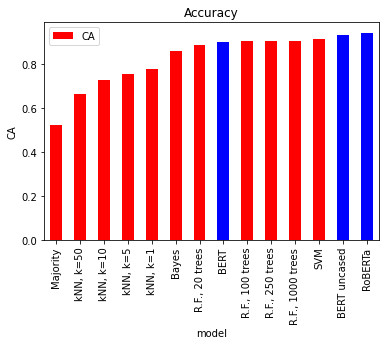

In [215]:
results2.plot.bar("model", "CA", color=results2["type"])
plt.ylabel("CA")
plt.title("Accuracy")

Text(0.5, 1.0, 'F1')

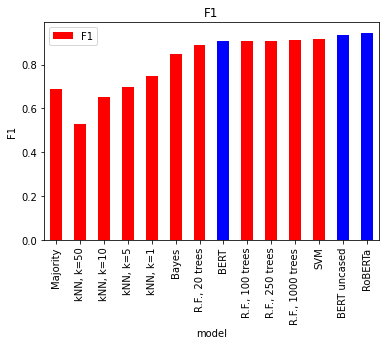

In [216]:
results2.plot.bar("model", "F1", color=results2["type"])
plt.ylabel("F1")
plt.title("F1")

The best classifier was RoBERTa with logistic regression as a classifier on top, beating all but the best of the baselines in both CA and F1.